In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import matplotlib.pyplot as plt
import random
import shutil
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
BASE_IMG_PATH = '/content/drive/Othercomputers/My MacBook Pro/OCT2017'
LITE_IMG_PATH = os.path.join(BASE_IMG_PATH, 'light-set/')
BATCH_SIZE = 32
IMG_HEIGHT = 299 # match image dimensions to inceptionv3
IMG_WIDTH = 299  # match image dimensions to inceptionv3
SEED = 42
SAMPLE_SIZE = 250

Check to make sure that the dataset shape is correct for each class.

In [7]:
for subdir in os.listdir(os.path.join(BASE_IMG_PATH, 'train')):
    file_count = len(os.listdir(os.path.join(BASE_IMG_PATH, "train", subdir)))
    if subdir == 'NORMAL':
        assert file_count == 26312, 'NORMAL file count is incorrect'
    elif subdir == 'DME':
        assert file_count == 11343, 'DME file count is incorrect'
    elif subdir == 'CNV':
        assert file_count == 37202, 'CNV file count is incorrect'
    elif subdir == 'DRUSEN':
        assert file_count == 8602, 'DRUSEN file count is incorrect'
    else:
        pass

print('Training set is clean')

Training set is clean


In [8]:
def sample_classes(n: int=250):
    '''
    Samples n files from each class of the training dataset.
    '''

    random.seed(SEED)
    TRAIN_PATH = os.path.join(BASE_IMG_PATH, 'train/')

    # prepare to write the samples to file
    samples = []

    for subdir in os.listdir(TRAIN_PATH):
        print(f'Sampling {subdir}')
        # list the files and their indexes
        subdir_files = os.listdir(os.path.join(TRAIN_PATH, subdir))
        sample_indexes = random.sample([ i for i in range(len(subdir_files))], SAMPLE_SIZE)
        for s in sample_indexes:
            # save the filename
            samples.append(subdir_files[s])
            try:
                shutil.move(
                    src=os.path.join(TRAIN_PATH, subdir, subdir_files[s]),
                    dst=os.path.join(LITE_IMG_PATH, subdir, subdir_files[s])
                )
                # print(f'Successfully sampled file {subdir_files[s]}')
            except Exception as err:
                print(f'Error occurred during copy for file {subdir_files[s]}: {err}')
    print('Sampling completed')
    return samples

def cleanup_classes():
    '''
    Moves all sampled files into their repspective training dataset class.
    '''

    random.seed(SEED)

    for subdir in os.listdir(LITE_IMG_PATH):
        print(f'Cleaning up {subdir}')
        subdir_files = os.listdir(os.path.join(LITE_IMG_PATH, subdir))
        for s in subdir_files:
            try:
                shutil.move(
                    src=os.path.join(LITE_IMG_PATH, subdir, s),
                    dst=os.path.join(BASE_IMG_PATH, 'train', subdir, s)
                )
                # print(f'Successfully moved file back to {s}')
            except Exception as err:
                print(f'Error occurred during copy for file {s}: {err}')
    print('Cleanup completed')
    

# Sample Dataset

In [9]:
# create the dataset (by sampling) for the light model
samples = sample_classes(n=250)

Sampling NORMAL
Sampling DME
Sampling CNV
Sampling DRUSEN
Sampling completed


In [10]:
samples

['NORMAL-2763635-1.jpeg',
 'NORMAL-8869683-19.jpeg',
 'NORMAL-9776999-3.jpeg',
 'NORMAL-1725838-8.jpeg',
 'NORMAL-60471-12.jpeg',
 'NORMAL-6508224-14.jpeg',
 'NORMAL-7076479-3.jpeg',
 'NORMAL-832190-1.jpeg',
 'NORMAL-1695472-14.jpeg',
 'NORMAL-8738660-15.jpeg',
 'NORMAL-2105194-9.jpeg',
 'NORMAL-1724756-1.jpeg',
 'NORMAL-3820638-2.jpeg',
 'NORMAL-918579-2.jpeg',
 'NORMAL-3068234-9.jpeg',
 'NORMAL-4933627-8.jpeg',
 'NORMAL-9286417-7.jpeg',
 'NORMAL-9961073-21.jpeg',
 'NORMAL-8603193-8.jpeg',
 'NORMAL-692554-7.jpeg',
 'NORMAL-7388269-1.jpeg',
 'NORMAL-3978593-5.jpeg',
 'NORMAL-3134896-5.jpeg',
 'NORMAL-98720-12.jpeg',
 'NORMAL-3416330-5.jpeg',
 'NORMAL-7731385-4.jpeg',
 'NORMAL-1957379-17.jpeg',
 'NORMAL-2377429-1.jpeg',
 'NORMAL-2327797-10.jpeg',
 'NORMAL-3816498-2.jpeg',
 'NORMAL-4921376-57.jpeg',
 'NORMAL-701919-4.jpeg',
 'NORMAL-4506603-2.jpeg',
 'NORMAL-306286-8.jpeg',
 'NORMAL-617956-1.jpeg',
 'NORMAL-9618077-2.jpeg',
 'NORMAL-1853526-2.jpeg',
 'NORMAL-7858342-1.jpeg',
 'NORMAL-230

# Data Preprocessing

In [11]:
# load training data
train_data = keras.utils.image_dataset_from_directory(
    directory=LITE_IMG_PATH,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    # shuffle=True,
    seed=SEED,
)

# load validation (test) data
validation_data = keras.utils.image_dataset_from_directory(
    directory=os.path.join(BASE_IMG_PATH, 'test'),
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    # shuffle=True,
    seed=SEED,
)

Found 1000 files belonging to 4 classes.
Found 1000 files belonging to 4 classes.


In [12]:
# configure the dataset for performance w/ buffered prefetching
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
validation_data = validation_data.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
# scale input pixels prior to sending them into the model
train_data = train_data.map(
    lambda x, y: (tf.keras.applications.inception_v3.preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)
validation_data = validation_data.map(
    lambda x, y: (tf.keras.applications.inception_v3.preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

# Create Baseline Model

In [14]:
# create the base model but omit the classification layer
base_model = InceptionV3(weights='imagenet', include_top=False)

# freeze the convolutional base (i.e. retain the weights)
base_model.trainable = False

# add classification head and prediction layer
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(4, activation='softmax')

# build the model
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

87924736/87910968 [==============================] - 1s 0us/step


In [15]:
# compile the model
BASE_LEARNING_RATE = 0.001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, None, None, 2048)  21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 4)                 8196      
                                                                 
Total params: 21,810,980
Trainable params: 8,196
Non-trainable params: 21,802,784
_________________________________________________________________


# Model Training

In [17]:
INITIAL_EPOCHS = 100

loss0, accuracy0 = model.evaluate(validation_data)

32/32 [==============================] - 339s 7s/step - loss: 1.4427 - accuracy: 0.2570


In [18]:
es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=5, restore_best_weights=True)
rlp = tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)

In [19]:
history = model.fit(train_data,
                    epochs=INITIAL_EPOCHS,
                    callbacks=[es, rlp],
                    validation_data=validation_data)

Epoch 1/100
32/32 [==============================] - 423s 10s/step - loss: 1.1746 - accuracy: 0.4770 - val_loss: 0.7585 - val_accuracy: 0.7630 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 8s 245ms/step - loss: 0.9001 - accuracy: 0.6430 - val_loss: 0.6026 - val_accuracy: 0.8140 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 8s 244ms/step - loss: 0.7818 - accuracy: 0.7000 - val_loss: 0.5244 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 9s 291ms/step - loss: 0.7129 - accuracy: 0.7240 - val_loss: 0.4754 - val_accuracy: 0.8640 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 8s 243ms/step - loss: 0.6622 - accuracy: 0.7570 - val_loss: 0.4390 - val_accuracy: 0.8770 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 8s 243ms/step - loss: 0.6206 - accuracy: 0.7800 - val_loss: 0.4117 - val_accuracy: 0.8830 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 8s 242ms/st

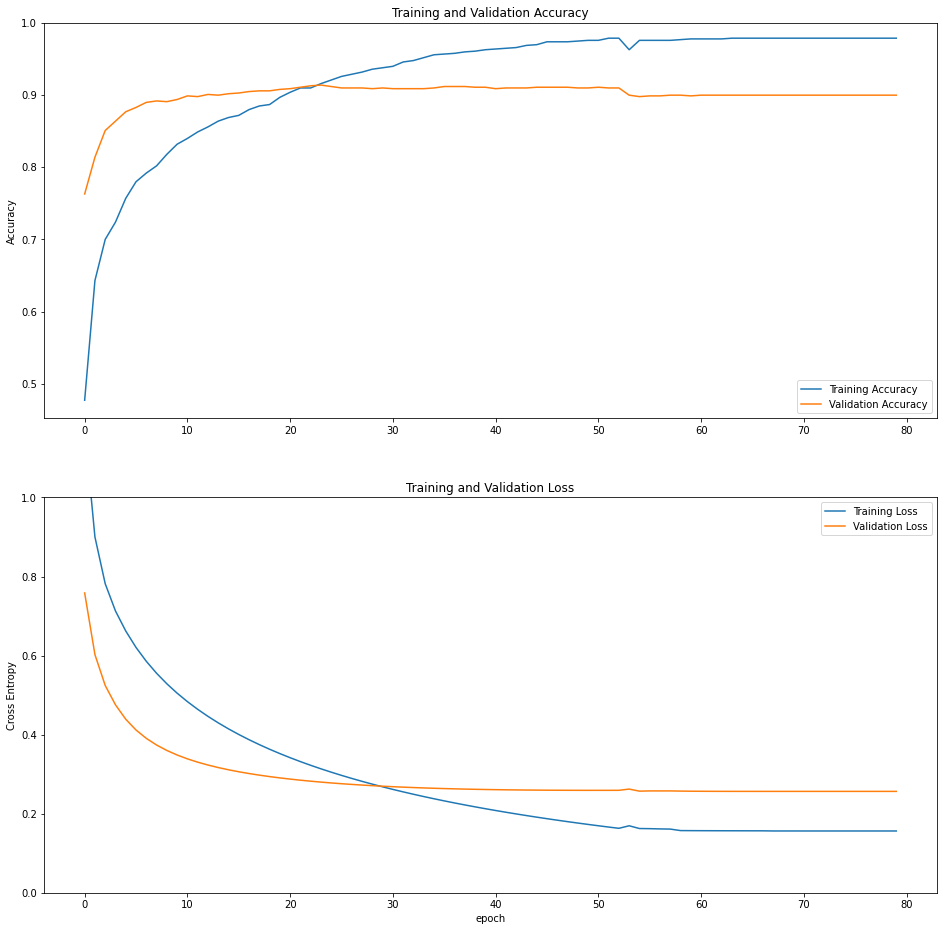

In [20]:
# plot learning curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [21]:
loss, accuracy = model.evaluate(validation_data)
print('Validation accuracy :', accuracy)

32/32 [==============================] - 4s 119ms/step - loss: 0.2565 - accuracy: 0.9000
Validation accuracy : 0.8999999761581421


In [22]:
!cd drive/MyDrive/Colab\ Notebooks/models

In [23]:
model.save('trained-light-inceptionv3-model-100epochs')

INFO:tensorflow:Assets written to: trained-light-inceptionv3-model-100epochs/assets


In [24]:
# move sampled files back to their respective directories
cleanup_classes()

Cleaning up CNV
Cleaning up DRUSEN
Cleaning up NORMAL
Cleaning up DME
Cleanup completed
